In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import numpy as np
from IPython.display import clear_output
import uuid

# Configuración para matplotlib en Colab
%matplotlib inline

In [2]:
# Tamaño del tablero
GRID_SIZE = 9
CELL_SIZE = 50


In [3]:

class SudokuGeneticAlgorithm():
    def __init__(self,
                 pop_size=100, 
                 max_generations=1000, 
                 mutation_rate=0.05,
                 sudoku_puzzle=[]):
        
        self.pop_size = pop_size
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.sudoku_puzzle = sudoku_puzzle
        self.best_fitness = 0
        self.fixed_positions = {(r, c) for r in range(GRID_SIZE) for c in range(GRID_SIZE) if sudoku_puzzle[r][c] != 0}

    def draw_grid(self,grid, generation, fitness_score):
        """
        Draw sudoku
        """
        clear_output(wait=True)
        plt.figure(figsize=(8, 8))
        plt.title(f"Generación: {generation} - Fitness: {fitness_score}", fontsize=14)
        #plt.imshow(np.ones((GRID_SIZE, GRID_SIZE)) * 0.1, cmap="gray", extent=[0, GRID_SIZE, 0, GRID_SIZE])
        plt.gca().set_facecolor((0.8, 0.8, 0.8))  # RGB: 0.8 es un gris claro
    
        # Dibujar cuadrícula
        for r in range(GRID_SIZE + 1):
            lw = 2 if r % 3 == 0 else 0.5
            plt.plot([0, GRID_SIZE], [r, r], 'k', linewidth=lw)
            plt.plot([r, r], [0, GRID_SIZE], 'k', linewidth=lw)
    
        # Añadir números
        for r in range(GRID_SIZE):
            for c in range(GRID_SIZE):
                if grid[r][c] != 0:
                    color = 'darkred' if (r, c) in self.fixed_positions else 'darkblue'
                    plt.text(c + 0.5, GRID_SIZE - r - 0.5, str(grid[r][c]),
                            ha='center', va='center', fontsize=14, color=color, fontweight='bold')
    
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.close() 
        
    def _generate_population_blocks(self, total_pop):
        """
        Generate intial population by trying to fill 3x3 blocks
        """
        population = []
    
        for _ in range(total_pop):
            individual = np.copy(self.sudoku_puzzle)
    
            for block_row in range(3):
                for block_col in range(3):
                    r_start, c_start = block_row * 3, block_col * 3
    
                    block_coords = [
                        (r, c)
                        for r in range(r_start, r_start + 3)
                        for c in range(c_start, c_start + 3)
                    ]
    
                    fixed_vals = set()
                    non_fixed_coords = []
    
                    for r, c in block_coords:
                        val = individual[r][c]
                        if (r, c) in self.fixed_positions:
                            fixed_vals.add(val)
                        else:
                            non_fixed_coords.append((r, c))
    
                    available = list(set(range(1, 10)) - fixed_vals)
                    np.random.shuffle(available)
    
                    for r, c in non_fixed_coords:
                        # Intentar colocar un valor que no esté en la fila ni columna
                        placed = False
                        for val in available:
                            if val not in individual[r, :] and val not in individual[:, c]:
                                individual[r][c] = val
                                available.remove(val)
                                placed = True
                                break
    
                        # Si no encontró valor "bueno", colocar aleatoriamente uno de los restantes
                        if not placed and available:
                            individual[r][c] = available.pop()
                        elif not placed:
                            # Ya no quedan valores, poner número aleatorio (fallback)
                            individual[r][c] = np.random.randint(1, 10)
    
            population.append(individual)
    
        return population

    def _generate_population(self,total_pop,rand=False):
        """
        Generate population with fixed position.
        """
        population = []
        for _ in range(total_pop):
            # New empty dashboard.
            current_sudoku_board = np.zeros((9, 9), dtype=int)
            # Create by row
            for r in range(9):
                available_numbers_row = list(range(1, 9))
                # Create by column
                for c in range(9):
                    # If the value is in fixed positions keep the numeber.
                    if (r,c) in self.fixed_positions:
                        fixed_value = self.sudoku_puzzle[r][c]
                        current_sudoku_board[r][c] = fixed_value
                        # Remove value select from available list
                        if fixed_value in available_numbers_row:
                            available_numbers_row.remove(fixed_value)
                            
                    # If there is not fixed position, set a new number.
                    else:
                        available_numbers_col = set([num for num in current_sudoku_board[:,c] if num!=0])
                        total_available = list(set(available_numbers_row) - set(available_numbers_col))

                        if len(total_available)>0:
                            current_sudoku_board[r][c] = np.random.choice(total_available,1)
                        elif rand:
                            current_sudoku_board[r][c] = int(np.random.choice(range(1,9)))
                        else:
                            current_sudoku_board[r][c] = 0
                            

            
            population.append(np.array(current_sudoku_board))
                
        return population
        
    def _compute_fitness(self, grid):
        """
        Penalize duplicated values
        """
        penalty = 0
    
        # Penalize by row
        for i in range(9):
            row = grid[i, :]
            penalty += (9 - len(set(row)))*(sum([1 for t in self.fixed_positions if t[0]==i])) 
    
        # Penalize by rcol
        for i in range(9):
            col = grid[:, i]
            penalty += (9 -len(set(col)))*(sum([1 for t in self.fixed_positions if t[1]==i]))
    
        # Penalize by block
        for i in range(3):
            for j in range(3):
                block = grid[i*3:(i+1)*3, j*3:(j+1)*3].flatten()
                penalty += 9 - len(set(block))
    
        total_fitness = 243 - penalty 
        return total_fitness


    def _crossover_row(self,p1, p2, probability=0.5):
        """
        Cross by rows with probability P
        """
        
        mask = np.random.rand(9) < probability
        child = np.where(mask[:, None], p1, p2)
        return child

    def _crossover_blocks(self, p1, p2):
        """
        Cross by blocks
        """
        child = np.copy(p1)
    
        for i in range(3):
            for j in range(3):
                if np.random.rand() < 0.5:
                    # Copiar bloque de p2 a child
                    for r in range(i*3, (i+1)*3):
                        for c in range(j*3, (j+1)*3):
                            if (r, c) not in self.fixed_positions:
                                child[r, c] = p2[r, c]
        return child


    def _mutate_simple(self,grid):
        """
        Simple mutation
        """
        
        mutation_mask = np.random.rand(*grid.shape) < self.mutation_rate
        random_values = np.random.randint(1, 10, grid.shape)
        
        mutated_grid = np.copy(grid)
        
        for r in range(9):
            for c in range(9):
                # Check if this position is marked for mutation AND it's NOT a fixed position
                # Else, the value remains as it was in the original grid.
                if mutation_mask[r][c] and (r, c) not in self.fixed_positions:
                    mutated_grid[r][c] = random_values[r][c]
        
        return mutated_grid
        
    def _mutate2(self, grid, max_attempts=5):
        mutated = np.copy(grid)
    
        for _ in range(max_attempts):
            # Elegir un bloque aleatorio
            block_row = np.random.randint(0, 3)
            block_col = np.random.randint(0, 3)
            r_start, c_start = block_row * 3, block_col * 3
    
            # Coordenadas no fijas dentro del bloque
            block_coords = [
                (r, c)
                for r in range(r_start, r_start + 3)
                for c in range(c_start, c_start + 3)
                if (r, c) not in self.fixed_positions
            ]
    
            if len(block_coords) < 2:
                continue 
    
            # Escoger dos celdas y hacer swap
            (r1, c1), (r2, c2) = random.sample(block_coords, 2)
            mutated[r1, c1], mutated[r2, c2] = mutated[r2, c2], mutated[r1, c1]
    
            # Si la mutación mejora el fitness o con cierta probabilidad, la dejamos
            old_fitness = self._compute_fitness(grid)
            new_fitness = self._compute_fitness(mutated)
            
            if new_fitness <= old_fitness or np.random.rand() < 0.5:
                break 
            else:
                # Revertir
                mutated[r1, c1], mutated[r2, c2] = mutated[r2, c2], mutated[r1, c1]
    
        return mutated
        

    def _display_progress(self, generation, best_solution, current_fitness,avg_fitness,draw=False):
        """
        Show the algo's progress in the console
        """
        print(f"Generation: {generation:4d} | Fitness: {current_fitness:3d} | Avg fitness {avg_fitness} |Max possible: 243")
        if draw:
            self.draw_grid(best_solution, generation, current_fitness)

    def _check_sequence(self,sequence):
        """
        Check if the sequence is correct
        """
        seen = set()
        for num in sequence:
            # 1-9
            if not (1 <= num <= 9):
                return False
            # Duplicated
            if num in seen:
                return False
            seen.add(num)
        # Good sequence
        return True
        
    def is_sudoku_valid(self, board):
        """
        Verify if the sudoku is correct.
        """
   
        # Verify rows
        for r in range(9):
            if not self._check_sequence(board[r, :],):
                print(f"There is a problem in row: {r+1}")
                return False
    
        # Verify cols
        for c in range(9):
            if not self._check_sequence(board[:, c]):
                print(f"There is a problem in column: {c+1}")
                return False
    
        # Verify block
        for block_row in range(3):
            for block_col in range(3):
                start_row = block_row * 3
                start_col = block_col * 3

                block = board[start_row:start_row + 3, start_col:start_col + 3].flatten()
                if not self._check_sequence(block):
                    return False
    
        # If Sudoku is well solved
        return True   
        
    def _local_improvement(self, individual):
        improved = np.copy(individual)
    
        for block_row in range(3):
            for block_col in range(3):
                r_start, c_start = block_row * 3, block_col * 3
    
                # Extraer coordenadas del bloque
                block_coords = [
                    (r, c)
                    for r in range(r_start, r_start + 3)
                    for c in range(c_start, c_start + 3)
                ]
    
                fixed_vals = set()
                non_fixed_coords = []
                block_vals = []
    
                for r, c in block_coords:
                    val = improved[r, c]
                    block_vals.append(val)
                    if (r, c) in self.fixed_positions:
                        fixed_vals.add(val)
                    else:
                        non_fixed_coords.append((r, c))
    
                # Contar ocurrencias
                val_counts = {}
                for val in block_vals:
                    if val != 0:
                        val_counts[val] = val_counts.get(val, 0) + 1
    
                # Detectar valores duplicados (excluyendo los fijos)
                duplicates = {val for val, count in val_counts.items() if count > 1 and val not in fixed_vals}
    
                # Eliminar duplicados en celdas no fijas
                seen = set()
                for r, c in non_fixed_coords:
                    val = improved[r, c]
                    if val in seen or val in duplicates:
                        improved[r, c] = 0
                    else:
                        seen.add(val)
    
                # Fill cells not filled
                empty_cells = [(r, c) for r, c in block_coords if improved[r, c] == 0]
                missing = list(set(range(1, 10)) - {improved[r, c] for r, c in block_coords})
                
                for val in missing:
                    best_cell = None
                    min_conflicts = float('inf')
                
                    for r, c in empty_cells:
                        # Contar conflictos en fila y columna
                        row_conflict = np.count_nonzero(improved[r, :] == val)
                        col_conflict = np.count_nonzero(improved[:, c] == val)
                        total_conflict = row_conflict + col_conflict
                
                        if total_conflict < min_conflicts:
                            min_conflicts = total_conflict
                            best_cell = (r, c)
                
                    if best_cell:
                        improved[best_cell] = val
                        empty_cells.remove(best_cell)
    
        return improved
        
    def create_individual(self,grid):
        return uuid.uuid5(uuid.NAMESPACE_DNS,str(grid))

    def remove_duplicates(self, population):
        seen = set()
        unique_population = []
    
        for individual in population:
            hash_id = self.create_individual(individual)
            if hash_id not in seen:
                seen.add(hash_id)
                unique_population.append(individual)
    
        return unique_population
    
    def start_genetic_algorithm(self):
        """Algoritmo genético principal"""
        population = self._generate_population_blocks(self.pop_size)
        no_improve_count = 0
        best_fitness = 0
        elite_count = 0
        self.history_best = set()
        
        for generation in range(self.max_generations):
            # Ordenar población por fitness descendente
            population.sort(key=lambda x: - self._compute_fitness(x))
            best_solution = population[0]
            current_fitness = self._compute_fitness(best_solution)
            fitness_scores = [self._compute_fitness(ind) for ind in population]
            avg_fitness = sum(fitness_scores) / len(fitness_scores)
            self.history_best = self.history_best.union([str(self.create_individual(best_solution))])
                       
            if current_fitness <= best_fitness:
                no_improve_count += 1
            else:
                best_fitness = current_fitness
                no_improve_count = 0
        
            if no_improve_count >= 5:
                # best_solution = self._local_improvement(population[1])
                for i in population[1:]:
                    if not str(self.create_individual(i)) in self.history_best:
                        best_solution = i
                        break
                    else:
                        population.pop(0)
                        
                self.mutation_rate += 0.001 
                no_improve_count = 0
                # population = [self._local_improvement(i) for i in self._generate_population_blocks(self.pop_size // 2)]

            print("BEST: ",str(self.create_individual(best_solution)))  
            
            self._display_progress(
                generation, 
                best_solution, 
                current_fitness,
                avg_fitness
            )
            
            #Stop the algorithm
            if current_fitness == 243:
                break

            parents = population[:int(self.pop_size*0.50)] 
            
            elite_count = int(0.05 * self.pop_size)
            elite = []
            
            for e in population[:elite_count]:
                elite.append(self._local_improvement(e))
                
            new_pop = [best_solution.copy()] + elite
    
            while len(new_pop) < self.pop_size:
                p1, p2 = random.choices(parents, k=2)
                child = self._mutate2(self._crossover_blocks(p1, p2))
                new_pop.append(child)

            population = self.remove_duplicates(new_pop )
            
    
        print("\nSolution not found")
        self._display_progress(
            generation, 
            best_solution, 
            current_fitness,
            avg_fitness,
            True
        )
        
        if self.is_sudoku_valid(best_solution):
            print("Sudoku solved")

        return best_solution

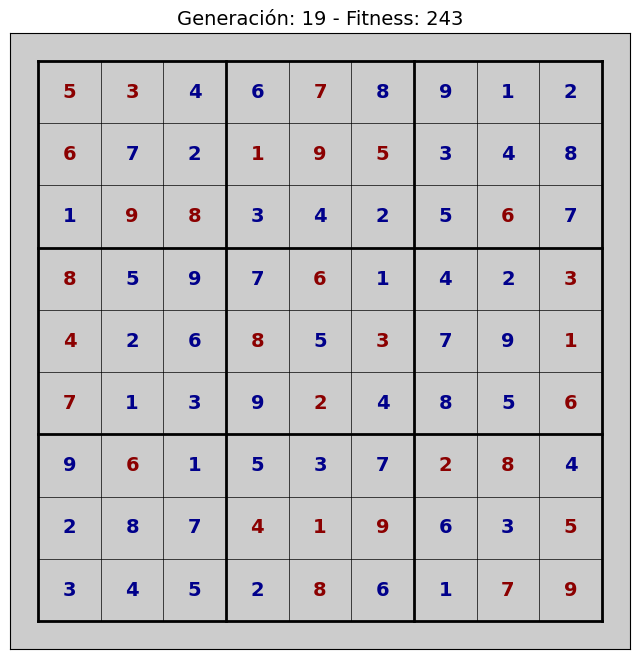

Sudoku solved


array([[5, 3, 4, 6, 7, 8, 9, 1, 2],
       [6, 7, 2, 1, 9, 5, 3, 4, 8],
       [1, 9, 8, 3, 4, 2, 5, 6, 7],
       [8, 5, 9, 7, 6, 1, 4, 2, 3],
       [4, 2, 6, 8, 5, 3, 7, 9, 1],
       [7, 1, 3, 9, 2, 4, 8, 5, 6],
       [9, 6, 1, 5, 3, 7, 2, 8, 4],
       [2, 8, 7, 4, 1, 9, 6, 3, 5],
       [3, 4, 5, 2, 8, 6, 1, 7, 9]])

In [4]:
sudoku_puzzle = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

genetic = SudokuGeneticAlgorithm(
    pop_size=500, 
    max_generations=1000,
    mutation_rate=0.01,
    sudoku_puzzle=sudoku_puzzle
)

genetic.start_genetic_algorithm()

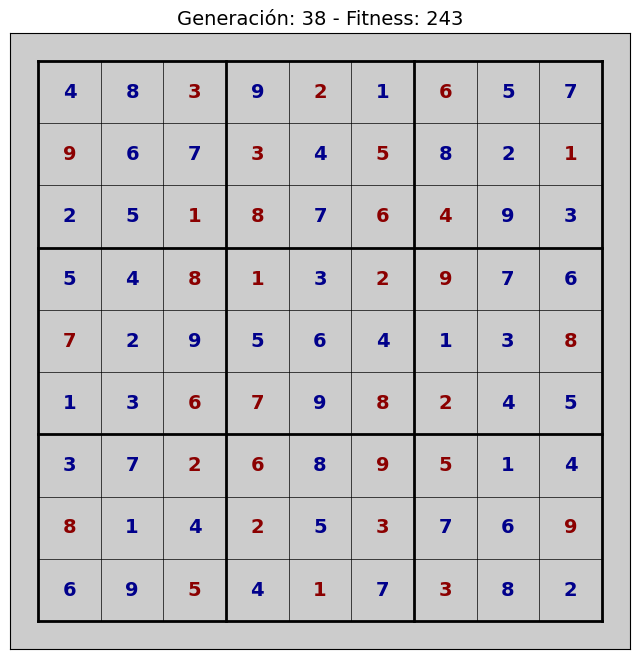

Sudoku solved


array([[4, 8, 3, 9, 2, 1, 6, 5, 7],
       [9, 6, 7, 3, 4, 5, 8, 2, 1],
       [2, 5, 1, 8, 7, 6, 4, 9, 3],
       [5, 4, 8, 1, 3, 2, 9, 7, 6],
       [7, 2, 9, 5, 6, 4, 1, 3, 8],
       [1, 3, 6, 7, 9, 8, 2, 4, 5],
       [3, 7, 2, 6, 8, 9, 5, 1, 4],
       [8, 1, 4, 2, 5, 3, 7, 6, 9],
       [6, 9, 5, 4, 1, 7, 3, 8, 2]])

In [5]:
# Tamaño del tablero
GRID_SIZE = 9
CELL_SIZE = 50

sudoku1 = [
    [0, 0, 3, 0, 2, 0, 6, 0, 0],
    [9, 0, 0, 3, 0, 5, 0, 0, 1],
    [0, 0, 1, 8, 0, 6, 4, 0, 0],
    [0, 0, 8, 1, 0, 2, 9, 0, 0],
    [7, 0, 0, 0, 0, 0, 0, 0, 8],
    [0, 0, 6, 7, 0, 8, 2, 0, 0],
    [0, 0, 2, 6, 0, 9, 5, 0, 0],
    [8, 0, 0, 2, 0, 3, 0, 0, 9],
    [0, 0, 5, 0, 1, 0, 3, 0, 0]
]

genetic = SudokuGeneticAlgorithm(
    pop_size=500, 
    max_generations=1000,
    mutation_rate=0.01,
    sudoku_puzzle=sudoku1
)

genetic.start_genetic_algorithm()

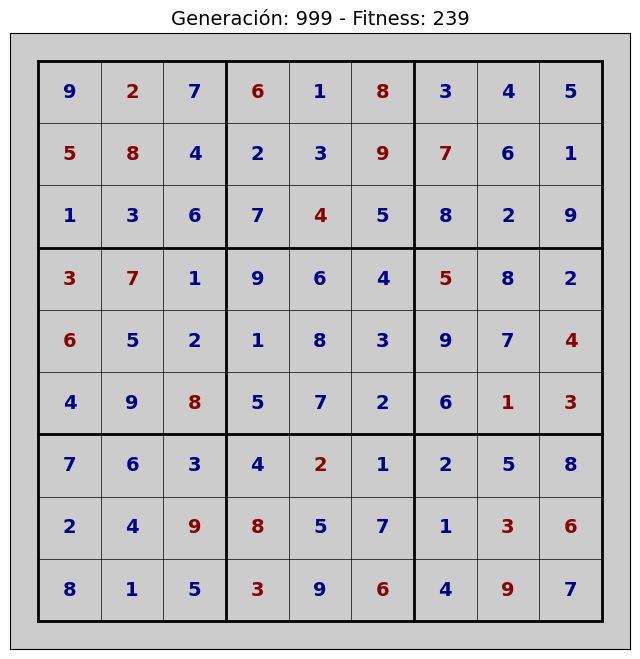

There is a problem in row: 7


array([[9, 2, 7, 6, 1, 8, 3, 4, 5],
       [5, 8, 4, 2, 3, 9, 7, 6, 1],
       [1, 3, 6, 7, 4, 5, 8, 2, 9],
       [3, 7, 1, 9, 6, 4, 5, 8, 2],
       [6, 5, 2, 1, 8, 3, 9, 7, 4],
       [4, 9, 8, 5, 7, 2, 6, 1, 3],
       [7, 6, 3, 4, 2, 1, 2, 5, 8],
       [2, 4, 9, 8, 5, 7, 1, 3, 6],
       [8, 1, 5, 3, 9, 6, 4, 9, 7]])

In [6]:
sudoku2= [
    [0, 2, 0, 6, 0, 8, 0, 0, 0],
    [5, 8, 0, 0, 0, 9, 7, 0, 0],
    [0, 0, 0, 0, 4, 0, 0, 0, 0],
    [3, 7, 0, 0, 0, 0, 5, 0, 0],
    [6, 0, 0, 0, 0, 0, 0, 0, 4],
    [0, 0, 8, 0, 0, 0, 0, 1, 3],
    [0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 9, 8, 0, 0, 0, 3, 6],
    [0, 0, 0, 3, 0, 6, 0, 9, 0]
]
genetic = SudokuGeneticAlgorithm(
    pop_size=500, 
    max_generations=1000,
    mutation_rate=0.01,
    sudoku_puzzle=sudoku2
)

genetic.start_genetic_algorithm()

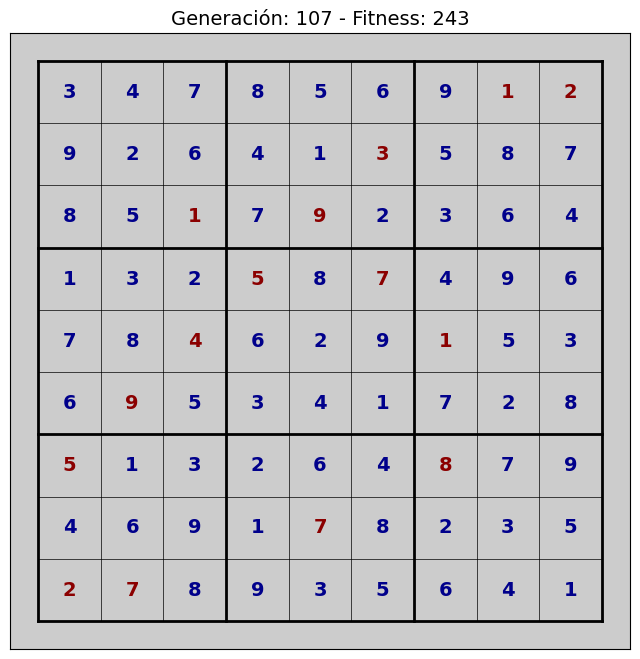

Sudoku solved


array([[3, 4, 7, 8, 5, 6, 9, 1, 2],
       [9, 2, 6, 4, 1, 3, 5, 8, 7],
       [8, 5, 1, 7, 9, 2, 3, 6, 4],
       [1, 3, 2, 5, 8, 7, 4, 9, 6],
       [7, 8, 4, 6, 2, 9, 1, 5, 3],
       [6, 9, 5, 3, 4, 1, 7, 2, 8],
       [5, 1, 3, 2, 6, 4, 8, 7, 9],
       [4, 6, 9, 1, 7, 8, 2, 3, 5],
       [2, 7, 8, 9, 3, 5, 6, 4, 1]])

In [7]:
sudoku_3 = [
    [0, 0, 0, 0, 0, 0, 0, 1, 2],
    [0, 0, 0, 0, 0, 3, 0, 0, 0],
    [0, 0, 1, 0, 9, 0, 0, 0, 0],
    [0, 0, 0, 5, 0, 7, 0, 0, 0],
    [0, 0, 4, 0, 0, 0, 1, 0, 0],
    [0, 9, 0, 0, 0, 0, 0, 0, 0],
    [5, 0, 0, 0, 0, 0, 8, 0, 0],
    [0, 0, 0, 0, 7, 0, 0, 0, 0],
    [2, 7, 0, 0, 0, 0, 0, 0, 0]
]
genetic = SudokuGeneticAlgorithm(
    pop_size=500, 
    max_generations=1000,
    mutation_rate=0.01,
    sudoku_puzzle=sudoku_3
)

genetic.start_genetic_algorithm()

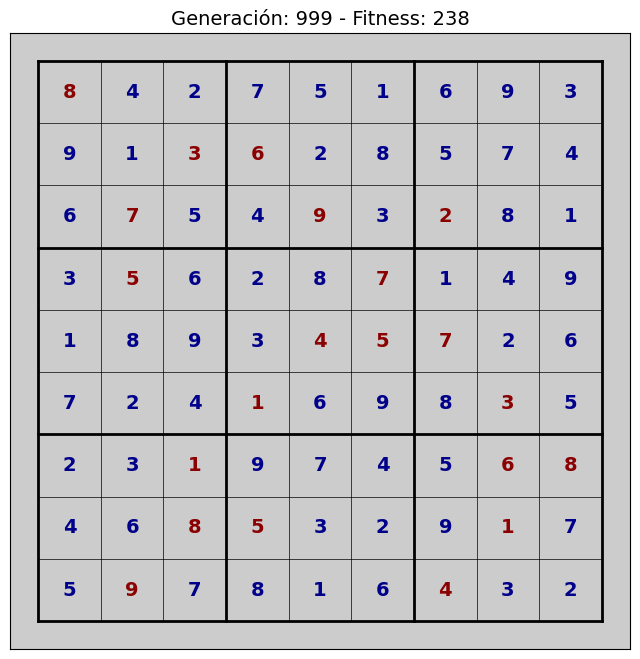

There is a problem in column: 7


array([[8, 4, 2, 7, 5, 1, 6, 9, 3],
       [9, 1, 3, 6, 2, 8, 5, 7, 4],
       [6, 7, 5, 4, 9, 3, 2, 8, 1],
       [3, 5, 6, 2, 8, 7, 1, 4, 9],
       [1, 8, 9, 3, 4, 5, 7, 2, 6],
       [7, 2, 4, 1, 6, 9, 8, 3, 5],
       [2, 3, 1, 9, 7, 4, 5, 6, 8],
       [4, 6, 8, 5, 3, 2, 9, 1, 7],
       [5, 9, 7, 8, 1, 6, 4, 3, 2]])

In [8]:
sudoku_4 =[
    [8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 6, 0, 0, 0, 0, 0],
    [0, 7, 0, 0, 9, 0, 2, 0, 0],
    [0, 5, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 4, 5, 7, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 3, 0],
    [0, 0, 1, 0, 0, 0, 0, 6, 8],
    [0, 0, 8, 5, 0, 0, 0, 1, 0],
    [0, 9, 0, 0, 0, 0, 4, 0, 0]
]

genetic = SudokuGeneticAlgorithm(
    pop_size=500, 
    max_generations=1000,
    mutation_rate=0.01,
    sudoku_puzzle=sudoku_4
)

genetic.start_genetic_algorithm()